Copyright (c) <2022>, <Regina Nockerts>
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

Thanks to: 
* https://www.youtube.com/watch?v=szczpgOEdXs
* https://www.youtube.com/watch?v=Osj0Z6rwJB4
* https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=IagGoafKLUwW

# Setup the Model #

In [1]:
import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from textwrap import wrap

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import transformers
#from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, BertTokenizer

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
my_plot_colors = ['darkviolet','tomato', 'teal']
happy_colors = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(happy_colors))

my_seed = 42
np.random.seed(my_seed)
torch.manual_seed(my_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# --------------- CAN be Skipped ---------------


In [67]:
# tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
# model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = BertForSequenceClassification.from_pretrained("bert-base-cased")
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

# Run an Initial Test #
## tokenization

In [68]:
tokens = tokenizer.encode("I haaaaaaated this, absolutely the WORST. 🙄", return_tensors='pt')

In [69]:
tokens[0]

tensor([  101,   146,  5871, 22118, 22118, 22118,  1906,  1142,   117,  7284,
         1103,   160,  9565,  9272,   119,   100,   102])

In [75]:
tokenizer.decode(tokens[0])


'[CLS] I haaaaaaated this, absolutely the WORST. [UNK] [SEP]'

In [5]:
sample_txt = "i HATE this"
encoding = tokenizer.encode_plus(
  sample_txt,
#  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'

  max_length=32,
  pad_to_max_length = True,
#  padding='max_length',
#  padding='longest',

  return_token_type_ids=False,
  return_attention_mask=True,
  return_tensors='pt')  # Return PyTorch tensors
print(encoding.keys())
encoding

dict_keys(['input_ids', 'attention_mask'])


c:\Users\rnocker\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': tensor([[  101,   178,   145, 13821,  2036,  1142,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

In [ ]:
# Returns dictionary with "input_ids" and "attention mask"
def my_encoder (text):
    encoding = tokenizer.encode_plus(
        text,
        truncation=True,
        add_special_tokens=True, # Add '[CLS]' and '[SEP]'
        max_length=81,
        pad_to_max_length=True,
        # padding='max_length',
        # padding='longest',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt')  # Return PyTorch tensors
    return encoding

sample_txt = "i HATE this"
my_encoder(sample_txt)

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

### Understanding the tokenization
Note that the tokenizer takes care of capitalization and handels (keeps) punctuation - which is good. But it does not recognize emojis (codes them as unknown and can not decode) and certain intentional misspellings (for emphasis, eg. "haaaaaaate"). 

The tokenizer also insertes the special codes needed for BERT, including padding.

## model

In [20]:
result = model(tokens)

In [21]:
print(result)
print(result.logits)
print(torch.argmax(result.logits))

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0435,  0.0999, -0.1842]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor([[ 0.0435,  0.0999, -0.1842]], grad_fn=<AddmmBackward0>)
tensor(1)


### Understanding the model results
logits=tensor([[ 4.8750,  1.7880, -0.8356, -3.0027, -2.0727]], ...)

For nlptown/bert-base-multilingual-uncased-sentiment:
* Remember that this model assumes/represents a 5-star rating system, so it gives the probability that the review is one-, two-, three-, four-, or five-star review. "The output from the model is a one-hot encoded list of scores. The position with the highest score represents the sentiment rating."
* So, the model gives the highest score (4.8750) at the 0 index, thus predicting a one-star review. 

For bert-base-un/cased, it gives the probability in each of the number of labels you set.

In [23]:
int(torch.argmax(result.logits))

1

## load some test data in project format

In [171]:
test2 = pd.read_csv("x_train_bert.csv", header=0, index_col=0)
test2.reset_index(inplace=True, drop=True)
test2.head()

# NOTE: May need to remove special characters

,id_stable,ContentClean
0,13340,Yeah I mean I think squeezing the Afghan peopl...
1,20675,How sweet and this poor little one looks to be...
2,63713,Biden's vetted Afghanistan refugees are commit...
3,70672,You're talking about Trump who: • Surrendered ...
4,50394,How can Canada best deliver on its commitment ...


## create a function to get the score

Note that:
* 'nlptown/bert-base-multilingual-uncased-sentiment': scale of 0 to 4
* 'bert-base-uncased': scale of 1 to 2

In [79]:
# 'nlptown/bert-base-multilingual-uncased-sentiment'
model = BertForSequenceClassification.from_pretrained("bert-base-cased")
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

def score(text):
    tokens = tokenizer.encode(text, return_tensors='pt')
    result = model(tokens)
    return result


def sentiment_score(text):
    tokens = tokenizer.encode(text, return_tensors='pt')
    result = model(tokens)
    return result.logits, (int(torch.argmax(result.logits)))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

SequenceClassifierOutput(loss=None, logits=tensor([[0.2266, 0.8074]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[0.3882, 0.8396]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [27]:
example1 = "I HATED this. Super shitty."
example2 = "so wonderful"
a, b = sentiment_score(example1)
c, d = sentiment_score(example2)

print(b)
print(d)
print()
print(a[0][0].item(), a[0][1].item(), a[0][2].item()) 
print(c[0][0].item(), c[0][1].item(), c[0][2].item()) 
# print(sentiment_score(test2.ContentClean.iloc[0]))  # "Yeah I mean I think squeezing the Afghan people and turning away asylum seekers is terrible but I'm not apoplectic because the president increased the price of milk by 40000%"
# print(len(test2.ContentClean.iloc[0]))
# a = tokenizer.encode(test2.ContentClean.iloc[0])
# print(len(a))

# num_labels for model only: 2
# 0.366519957780838 0.43863701820373535 -0.22755415737628937
# 0.2927599549293518 0.4305158257484436 -0.33457422256469727

# num_labels for model and tokenizer: 3
# -0.5821682214736938 -0.11438198387622833 -0.006723061203956604
# -0.610467791557312 -0.14131410419940948 0.0883176177740097

2
2

0.14358285069465637 -0.3238496780395508 0.19826778769493103
0.10784652829170227 -0.28633183240890503 0.3512628376483917


In [32]:
# test2.drop(['sentiment'], inplace = True, axis = 1)
# test2.head(1)

,ContentClean
0,Yeah I mean I think squeezing the Afghan peopl...


In [53]:
test2['sentiment'] = test2["ContentClean"].apply(lambda x: sentiment_score(x[:512]))  
# limited to 512 tokens per row to be passed. If you need more than that, you would need to do this multiple times and append them together or something

In [54]:
print(test2['sentiment'].value_counts())
test2.tail(10)  # 1 1 1 1 5 1 1 5 4 1 1 1

3    741
1      1
Name: sentiment, dtype: int64


,ContentClean,sentiment
732,"This festive season, the Trust has made a dona...",3
733,O baji thori research krliya kro? Jahan daikha...,3
734,One of the biggest admissions yesterday during...,3
735,The problem is we are looking at a refugee cri...,3
736,I’m not trying to downplay the issue in Afghan...,3
737,Ok let the questions being. Did the Terrorist ...,3
738,Sooooooo agree! Now then talk us through Afgha...,3
739,"Today I’m voting to pass the ALLIES Act, which...",3
740,"Man, I know this migrant thing is bad but coul...",3
741,why is Afghan army clicking pictures of terror...,3


In [50]:
test2["ContentClean"].iloc[739]

'Today I’m voting to pass the ALLIES Act, which will protect the lives of those who served alongside American troops in Afghanistan by expanding and strengthening the Special Immigrant Visa program. #TakeThemToo'

The BERT base un/cased is not working as I had hoped. I'm getting all 1s. Not sure why.

# --------------- Can start from HERE ---------------
# Encode for Tuning
### choose model and tokenizer

In [2]:
mod_name = "bert-base-cased"
# model = BertForSequenceClassification.from_pretrained(mod_name)
model = BertModel.from_pretrained(mod_name)
tokenizer = BertTokenizer.from_pretrained(mod_name)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### load the data

In [3]:
tweets_data = pd.read_csv("tweets_data_bert.csv", header=0, index_col=0)
tweets_data.drop("y_sent", inplace=True, axis=1)
tweets_data.head()

,id_stable,ContentClean,label_sent,y_bert
0,170314,Per a White House official: Biden and Harris m...,neutral,1
1,192623,Afghan Refugee kid educated in Iran wins this ...,happy,2
2,106982,Not only did Trump stop processing asylum & re...,disgust,0
3,31609,An Afghan refugee demands the US not forget he...,plea - disgust,0
4,152666,One moment you hate refugees and the next you ...,hopeful,2


In [4]:
print(tweets_data.info())
tweets_data.ContentClean.iloc[4]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1211 entries, 0 to 1210
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_stable     1211 non-null   int64 
 1   ContentClean  1211 non-null   object
 2   label_sent    1211 non-null   object
 3   y_bert        1211 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 47.3+ KB
None


"One moment you hate refugees and the next you beg for them. Or is it that you don't like Latino? Frustrated with Biden, evangelical leaders are tightening the screws, calling resettlement of Afghan refugees a 'moral urgency'"

### Find the number of tokens needed
BERT needs all rows to have the same number of tokens, so will truncate or pad to the desired cutoff. So we need to find the right number. 

More tokens = longer to train. Fewer tokens = lost information.

In [5]:
token_lens = []
for text in tweets_data.ContentClean:
    tokens = tokenizer.encode(text, max_length=512, truncation=True)
    token_lens.append(len(tokens))

Text(0.2, 0.95, 'Max number of tokens: 141')

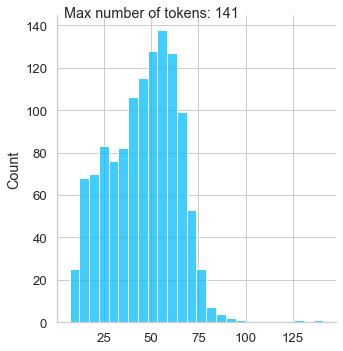

In [6]:
sns.displot(token_lens);
plt.figtext(.2, .95, "Max number of tokens: {}".format(max(token_lens)))

NOTE that this will be different with different tokenizer models.

bert-base-cased:
* I think we can pretty comfortably cut it off at 100. We can go up to 141 in the end if it doesn't take too long to train.

bert-base-uncased:
* Cut off at 81

### Some necessary functions
Extends the torchData dataset with a class.

In [7]:
class myDataset(Dataset): # class myDataset(data.Dataset):  #class GPReviewDataset(Dataset):
    # Constructor
    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # length method
    def __len__(self):
        return len(self.tweets)
    
    # get item method
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'

            max_length = self.max_len,
            pad_to_max_length = True,
#            padding='max_length',
#            truncation=True,
#            padding='longest',

            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt')  # Return PyTorch tensors
        
        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype = torch.long)
        }

In [8]:
### SET CONSTANTS ###
max_len = 100
batch_size = 8
epochs = 50

In [9]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = myDataset(
        tweets = df.ContentClean.to_numpy(),
        targets = df.y_bert.to_numpy(),  #should y_bert be something else? sentiment?
        tokenizer = tokenizer,
        max_len = max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0    # May need to change this for my personal machine.
    )

# Divide into train and test sets
Keep stratification of train and validation sets

### -------------- BOOKMARK -------------
I would like to try to figure out how to do this with k-fold cross validaton

In [10]:
data_train, data_test = train_test_split(tweets_data, test_size = 0.3, random_state = my_seed, stratify = tweets_data.y_bert.values)
data_val, data_test = train_test_split(data_test, test_size = 0.5, random_state = my_seed, stratify = data_test.y_bert.values)

0    512
1    178
2    157
Name: y_bert, dtype: int64
0    110
1     38
2     34
Name: y_bert, dtype: int64
0    110
1     39
2     33
Name: y_bert, dtype: int64


C:\Users\rnocker\AppData\Local\Temp\ipykernel_5320\4166038508.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


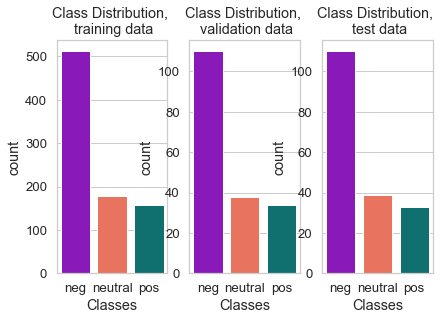

In [11]:
print(data_train["y_bert"].value_counts())
print(data_val["y_bert"].value_counts())
print(data_test["y_bert"].value_counts())

#plt.figure(figsize=(4, 18))

fig, ax =plt.subplots(1,3)
sns.countplot(x=data_train["y_bert"], palette=my_plot_colors, ax=ax[0]).set_xticklabels(["neg", "neutral", "pos"])
ax[0].set_title('Class Distribution, \n training data')
ax[0].set_xlabel('Classes')

sns.countplot(x=data_val["y_bert"], palette=my_plot_colors, ax=ax[1], ).set_xticklabels(["neg", "neutral", "pos"])
ax[1].set_title('Class Distribution, \n validation data')
ax[1].set_xlabel('Classes')

sns.countplot(x=data_test["y_bert"], palette=my_plot_colors, ax=ax[2], ).set_xticklabels(["neg", "neutral", "pos"])
ax[2].set_title('Class Distribution, \n test data')
ax[2].set_xlabel('Classes')

fig.show()

## load the data
with the data loader created above

In [12]:
train_data_loader = create_data_loader(data_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(data_val, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(data_test, tokenizer, max_len, batch_size)

## testing to see how it works

In [13]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\rnocker\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [14]:
print(data['input_ids'].shape) # Should get 8 (batch size) with 1 feature and 100 tokens.

torch.Size([4, 100])


# Using the BERT model 
## testing

In [15]:
sample_txt = "Why does it keep raining outside EVERY day?"
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length = 32,
  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids = False,
  #pad_to_max_length = True,
  padding = 'longest',
  return_attention_mask = True,
  return_tensors = 'pt',  # Return PyTorch tensors
)

In [16]:
# # NOTE: do not run this twice.
# output = model(
#     input_ids = encoding['input_ids'],
#     attention_mask = encoding['attention_mask']
# )

In [19]:
# print(output.pooler_output.shape)
# print(output.last_hidden_state.shape)

torch.Size([1, 768])
torch.Size([1, 15, 768])


In [18]:
# model.config.hidden_size

768

## build the sentiment classifier


In [16]:

# set the number of classes
# feed the data to the model
# apply drop-out for regularization
# append a fully-connected output layer
# cross-entropy loss function on the output

class SentimentClassifier(nn.Module):
    # constructor
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(mod_name, return_dict = False)
        self.drop = nn.Dropout(p=0.3)  # probability of dropout: 0.3
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)  
            # number of hidden units in the model - uses the model config so that you could use the 
            # same implementation to run the full model

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        output = self.drop(pooled_output)  #output.pooler_output
        return self.out(output)

In [17]:
class_names = ["neg", "neu", "pos"]
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### testing

In [22]:
# # NOTE: "data" is the single batch of "data_train" that was loaded above.

# input_ids = data['input_ids'].to(device)
# attention_mask = data['attention_mask'].to(device)

# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length

torch.Size([8, 100])
torch.Size([8, 100])


In [23]:
# # Pass "data" results to the model; get back the per-class probabilities for each instance in the batch.
# model(input_ids, attention_mask)

tensor([[-0.7269, -0.2813, -0.2445],
        [-0.3820, -0.1669,  0.1120],
        [-0.0489, -0.5614, -0.0866],
        [-1.1027, -0.6596, -0.5036],
        [ 0.2755, -0.8120, -0.7849],
        [-1.0336, -0.7806, -0.6999],
        [-0.7187, -0.5880, -0.4263],
        [-0.7449, -1.2569, -0.6528]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [24]:
# data_train.head(8)

,id_stable,ContentClean,label_sent,y_bert
989,180896,Email address for Afghan interpreters to apply...,disgust,0
104,87982,O baji thori research krliya kro? Jahan daikha...,na,1
10,132517,Kent Refugee Action Network need your help to ...,plea - fear,0
840,101637,does anyone have good resources for supporting...,neutral,1
1033,102062,Hey I can tell you about an SIV applicant & hi...,plea - fear,0
928,138497,A 3 star hotel accommodation in #Sheffield hou...,disgust,0
536,102829,Turkey cannot take new refugee ‘burden’ from A...,neutral,1
404,79189,Assets at Dyess Air Force Base have been assis...,happy,2


# Training

BERT authors' recommendations for fine-tuning:
* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

"Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy."
- https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=A8522g7JIu5J

In [18]:
# Note: the optimizer and settings are selected to match the BERT paper.
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)


c:\Users\rnocker\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
# returns the rate of correct predictions, and the mean loss
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_preds = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_preds += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # combats "exploding" gradients making the model unstable        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_preds.double() / n_examples, np.mean(losses)

In [20]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_preds = 0

  with torch.no_grad():  # disables the gradient function, to make torch faster.
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_preds += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_preds.double() / n_examples, np.mean(losses)

### create training group with above functions

In [21]:
torch.cuda.empty_cache()
max_split_size_mb = 10

In [22]:
# to store training and validation losses and accuracies
# 50 min to run on the training data

history = defaultdict(list)
best_accuracy = 0

for e in range(epochs):
    print(f'Epoch: {e + 1}/{epochs}')
    print('-'*10)

    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(data_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(data_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy: # Starting w 0, so we save the first model by default
        torch.save(model.bert.state_dict(), 'best_model_state.bin')
        model.bert.config.to_json_file('best_model_config.json')
        tokenizer.save_vocabulary('./')
        best_accuracy = val_acc

Epoch: 1/50
----------


c:\Users\rnocker\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 0.9769415472335411 accuracy 0.5832349468713105
Val loss 0.8887928717810175 accuracy 0.6043956043956045

Epoch: 2/50
----------
Train loss 1.005374992512307 accuracy 0.5914994096812278
Val loss 0.9833793717881908 accuracy 0.6043956043956045

Epoch: 3/50
----------
Train loss 0.9637017882657501 accuracy 0.58913813459268
Val loss 0.9366062568581622 accuracy 0.6043956043956045

Epoch: 4/50
----------
Train loss 0.9210498574066837 accuracy 0.5914994096812278
Val loss 0.9357088441434114 accuracy 0.6043956043956045

Epoch: 5/50
----------
Train loss 0.8995738078681927 accuracy 0.6257378984651711
Val loss 1.0158758037116216 accuracy 0.5934065934065934

Epoch: 6/50
----------
Train loss 0.8578494760506558 accuracy 0.6587957497048406
Val loss 0.8873039425715156 accuracy 0.6428571428571429

Epoch: 7/50
----------
Train loss 0.7382936354831986 accuracy 0.6989374262101534
Val loss 0.9324137699668822 accuracy 0.6373626373626374

Epoch: 8/50
----------
Train loss 0.7114288506036589 accurac

In [ ]:
train_hist_acc = []
for line in history['train_acc']:
    train_hist_acc.append(line.item())
train_hist_acc

In [ ]:
val_hist_acc = []
for line in history['val_acc']:
    val_hist_acc.append(line.item())
val_hist_acc

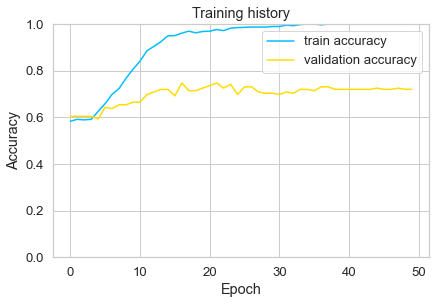

In [62]:
plt.plot(train_hist_acc, label='train accuracy')
plt.plot(val_hist_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# ---------- BOOKMARK ------------
https://www.youtube.com/watch?v=8N-nM3QW7O0 (24:07)

To anyone who is doing this tutorial on the latest version of transformers/huggingbox, you need to change the line
* self.bert = BertModel.from_pretrained('bert-base-cased')
to
* self.bert = BertModel.from_pretrained('bert-base-cased', return_dict=False)


the latest version of  transformers library, the bert_model outputs an object and not a tuple, so had to google and fix that like this to run the notebook.

output = bert_model(
  input_ids=data['input_ids'], 
  attention_mask=data['attention_mask']
)

output.last_hidden_state
output.pooler_output


N.B. in the text tutorial, I had to replace F.softmax with nn.functional.softmax.

# NOTES
1. The top layer of BERT can be modified to add the pooled layer output for text tokens which might improve classification performance.
2. The top layer of BERT can be modified to add numerical extra features to further improve classification performance;
3. Overfitting poses the most difficult challenge in this experiment, reducing its generalizability.
